# Setup

## CMD Args

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from pathlib import Path
import os, sys
import shutil
from time import sleep
from tqdm import tqdm
import csv

## Data Loading

In [239]:
filename = "IBM_2023-11-22.csv"

current_path_raw = os.getcwd()
current_path = Path(current_path_raw)
stored_path = str(current_path.parent) + "/sample_data/" + filename

stock_data = [] # [(datetime string, price)]

with open(stored_path) as file:
    # file structure (cols): date,open,high,low,close,volume
    
    reader = csv.reader(file)
    next(reader, None) # Skip header row
    
    for row in reader:    
        stock_data.append((row[0], row[1]))
        
stock_data = stock_data[::-1]

In [240]:
# Date range
print(stock_data[0][0])
print(stock_data[-1][0])

2023-10-31 04:54:00
2023-11-21 19:59:00


# Helper Functions

## General Data Wrangling

In [252]:
def plot_line_chart(datetimes, prices):
    xpoints = np.array(datetimes)
    ypoints = np.array(prices)

    plt.plot(xpoints, ypoints)
    plt.show()
    
    
def plot_line_chart_seaborne(datetimes, prices, ticker_symbol):
    df = pd.DataFrame(list(zip(datetimes, prices)),
               columns =['Time', 'Prices'])
    
    plt.figure(figsize=(14,5))
    
    sns.set_style("ticks")
    chart = sns.lineplot(data=df,x="Time",y='Prices',color='firebrick', label=ticker_symbol)

    plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
    locator = mdates.DayLocator(interval=70)
    chart.xaxis.set_major_locator(locator)
    
    plt.legend(loc="upper right")
    plt.show()
    
def split_into_datetimes_prices(stock_data):
    datetimes, prices = zip(*stock_data)
    return datetimes, map(float, prices)
    
# day in the format: 'YYYY-MM-DD'
def get_day_data(stock_data, day):
    return list(filter(lambda entry: entry[0].startswith(day),stock_data))

def get_day_data_cropped(stock_data, day):
    # Drop first 70 and last 40 entries due to missing data entries at the edges -> MAGIC NUMBERS (potential replacement)
    res = get_day_data(stock_data, day)
    res = res[70:-40]
    return res

def get_days(stock_data):
    datetimes, _ = split_into_datetimes_prices(stock_data)
    days = list(map(lambda entry: entry.split(' ')[0],datetimes))
    unsorted_unique = list(set(days))
    return sorted(unsorted_unique)

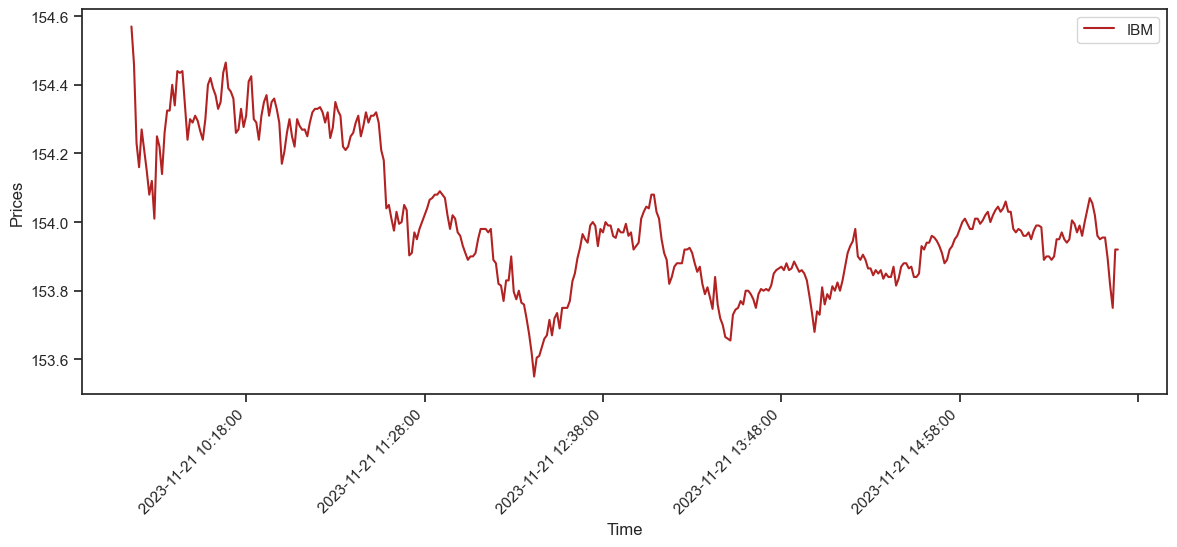

In [60]:
datetimes, prices = split_into_datetimes_prices(get_day_data_cropped(stock_data, "2023-11-21"))
plot_line_chart_seaborne(datetimes, prices, "IBM")

## Providing Intervals

In [222]:
def get_intervals(stock_data, interval_size_min = 15):
    datetimes, prices = split_into_datetimes_prices(stock_data)
    
    df = pd.DataFrame(list(zip(datetimes, prices)),
               columns =['Time', 'Prices'])
    
    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index(['Time'])
        
    
    groups = df.groupby(pd.Grouper(freq = "15Min"))
     
    """
    groups type: pandas.core.groupby.generic.DataFrameGroupBy
    
    Access like this:
        groups.get_group(pd.Timestamp("2023-11-21 09:30:00"))
        
    OR like this:
        for key, sub_df in groups:
            print(sub_df.iloc[0:10])
            break
    """
    
    intervals = []
    
    # convert to more handy data type
    for key, sub_df in groups:
        intervals.append((key, sub_df))
                
    return intervals

# Analysis

In [256]:
# Get all intervals
intervals = []

for day in get_days(stock_data):
    intervals.extend(get_intervals(get_day_data_cropped(stock_data, day)))

In [258]:
count_positive =0
count_negative = 0
count_total = 0

for interval in intervals:
    key, sub_df = interval
    
    diff = (sub_df.values[-1] - sub_df.values[0])
    
    if diff > 0:
        count_positive += 1
    elif diff < 0:
        count_negative += 1
        
    count_total += 1
    

print(f"{count_positive} out of {count_total} were positive. Making for {(round(count_positive/count_total, 2))*100}%.")
print(f"{count_negative} out of {count_total} were negative. Making for {(round(count_negative/count_total, 2))*100}%.")

235 out of 474 were positive. Making for 50.0%.
216 out of 474 were negative. Making for 46.0%.
